# Assignment 5: Text Analytics: Bag-of-Words

**Mukund Dhar,
UCF ID: 5499369**

# Test set accuracy: **93.1067%**

In [74]:
# load the libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.metrics import accuracy_score

In [75]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
# load data
candidate1_tweets = pd.read_csv("seanhannity_tweets.csv")
candidate2_tweets = pd.read_csv("jbouie_tweets.csv")

In [77]:
# clean text data
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # replace NaN values with empty strings
    if isinstance(text, float) and np.isnan(text):
        text = ""
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove digits
    text = re.sub(r"\d+", "", text)
    # convert to lowercase and remove leading/trailing whitespace
    text = text.lower().strip()
    # replace consecutive whitespace with a single space
    text = re.sub(r"\s+", " ", text)

    text = re.sub(r"http\S+", "", text) # remove URLs
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text) # remove non-alphanumeric characters
    text = re.sub(r"\b\w{1,2}\b", "", text) # remove short words

    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

candidate1_tweets["text_clean"] = candidate1_tweets["text"].apply(clean_text)
candidate2_tweets["text_clean"] = candidate2_tweets["text"].apply(clean_text)

# replace NaN values with empty strings
candidate1_tweets["text_clean"].fillna("", inplace=True)
candidate2_tweets["text_clean"].fillna("", inplace=True)

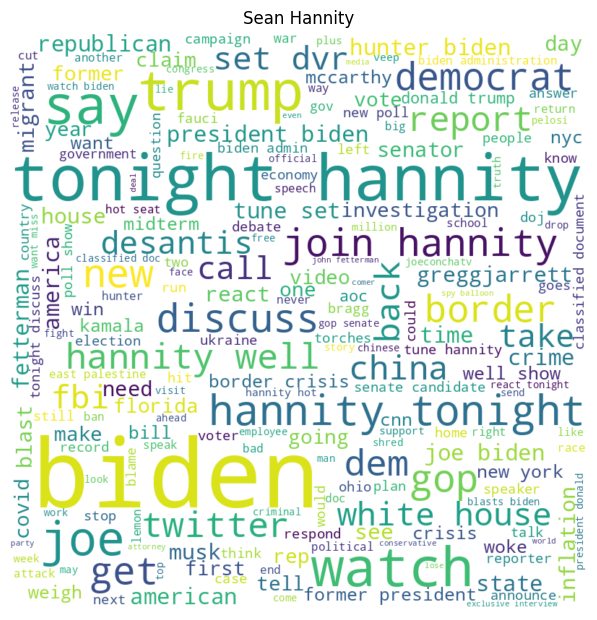

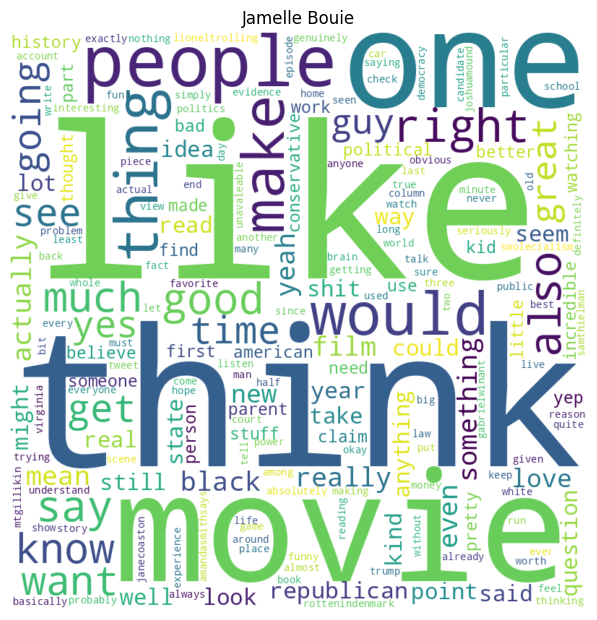

In [78]:
# create word clouds
wordcloud1 = WordCloud(width = 800, height = 800, background_color ='white', 
                       stopwords = set(), min_font_size = 10).generate(' '.join(candidate1_tweets["text_clean"]))
wordcloud2 = WordCloud(width = 800, height = 800, background_color ='white', 
                       stopwords = set(), min_font_size = 10).generate(' '.join(candidate2_tweets["text_clean"]))

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud1, interpolation='bilinear') 
plt.axis("off") 
plt.title("Sean Hannity")
plt.tight_layout(pad = 0) 
plt.show()

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud2,  interpolation='bilinear') 
plt.axis("off") 
plt.title("Jamelle Bouie")
plt.tight_layout(pad = 0) 
plt.show()

In [79]:
def visualize_term_freqs(df, candidate):
    # Generate a count of each term in the cleaned text
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df["text_clean"])
    freqs = np.array(np.sum(X, axis=0))[0]
    terms = vectorizer.get_feature_names_out()
    # Create a DataFrame to hold the term and frequency data
    term_freq_df = pd.DataFrame({"term": terms, "freq": freqs})
    # Sort by frequency
    term_freq_df = term_freq_df.sort_values(by="freq", ascending=False)
    # Plot bar chart of the top 20 terms
    plt.figure(figsize=(10, 6))
    plt.bar(x=term_freq_df["term"][:20], height=term_freq_df["freq"][:20])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Term Frequencies for {candidate}")

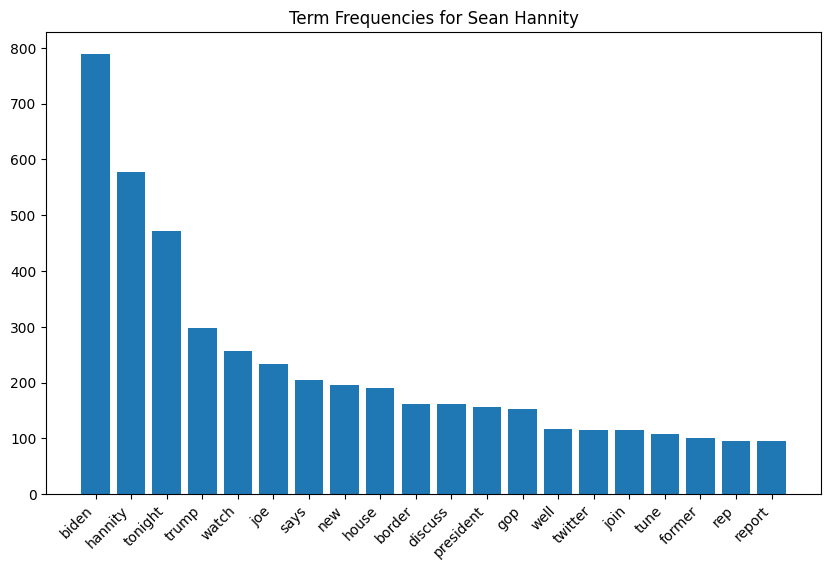

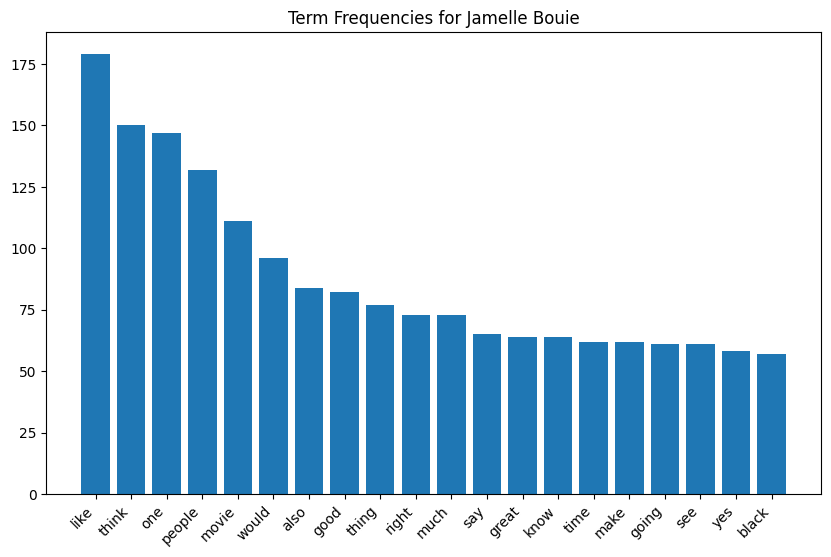

In [80]:
# create term frequency plots
visualize_term_freqs(candidate1_tweets, "Sean Hannity")
visualize_term_freqs(candidate2_tweets, "Jamelle Bouie")

In [81]:
# create document-term matrix
candidate1_tweets['tweeter'] = 'Sean Hannity'
candidate2_tweets['tweeter'] = 'Jamelle Bouie'

data = pd.concat([candidate1_tweets, candidate2_tweets], ignore_index=True)


In [82]:
X = data.drop('tweeter', axis=1)
y = data['tweeter']
y_binary = np.where(y == 'Sean Hannity', 0, 1)
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(X["text_clean"])

In [83]:
# Perform Variable Selection

kbest = SelectKBest(chi2, k=1000)
X_kbest = kbest.fit_transform(X, y_binary)

In [84]:
# split data into train-test subsets
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y_binary, test_size=0.2, random_state=42)

# build logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [85]:
# Get the test statistic and p-value for each term's coefficient
feature_names = vectorizer.get_feature_names_out()
selected_features = np.array(feature_names)[kbest.get_support()]
coefs = pd.DataFrame({'test_statistic': model.coef_[0], 'p_value': [2 * (1 - norm.cdf(abs(x))) for x in model.coef_[0]]}, index=selected_features)


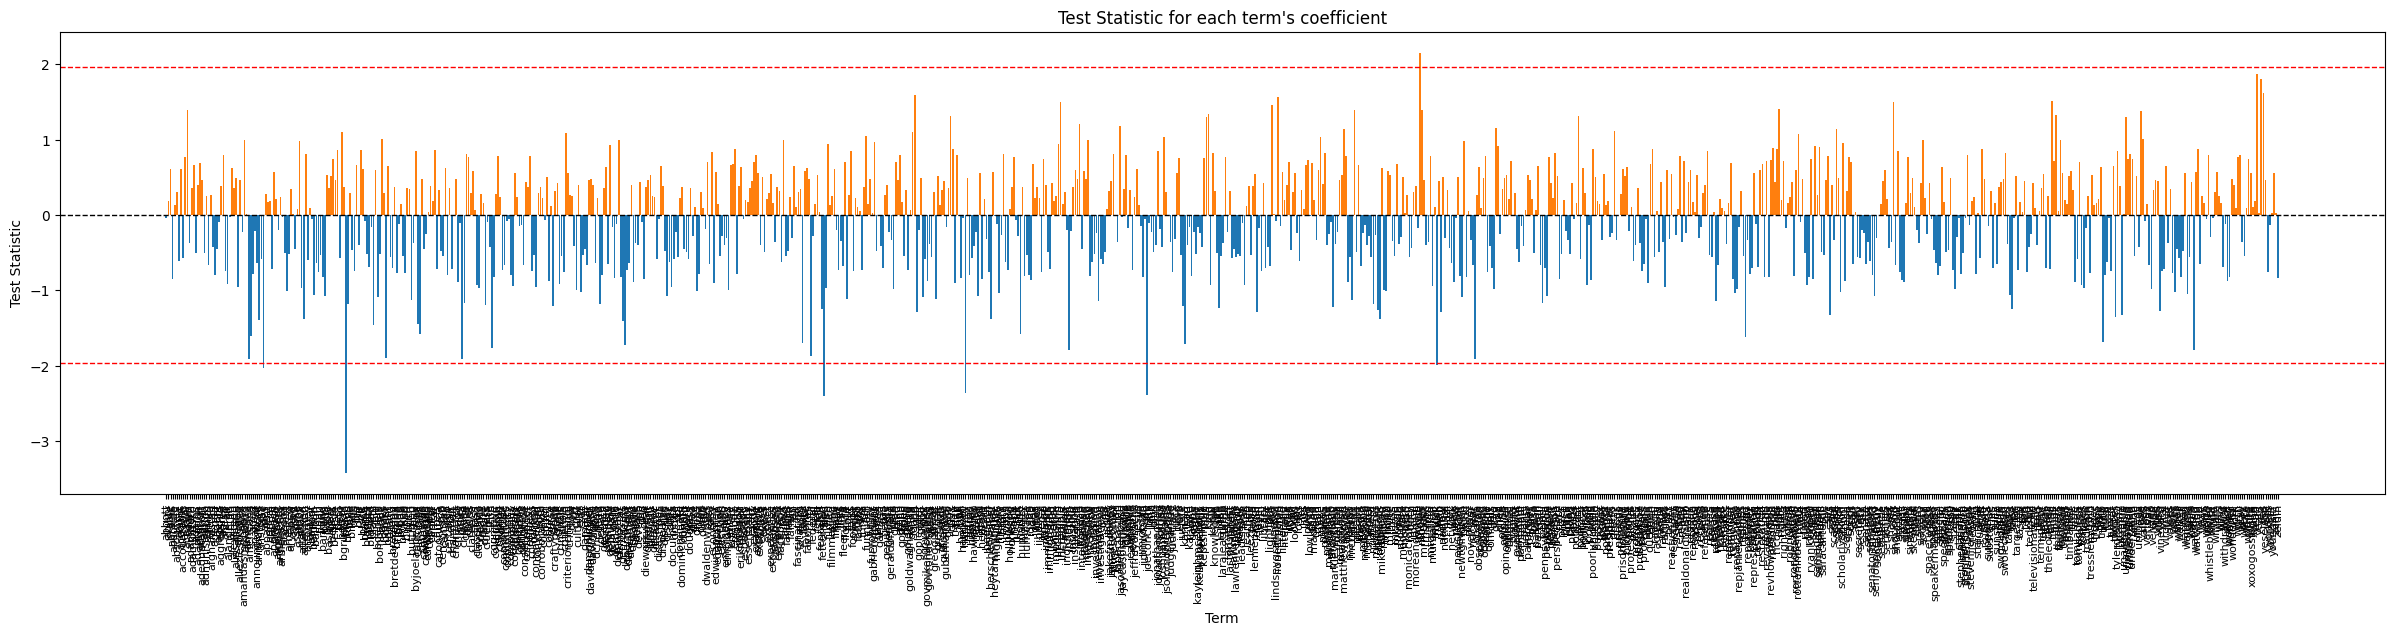

In [86]:
# Visualize the test statistic for each term's coefficient
fig, ax = plt.subplots(figsize=(30, 6))
colors = ['C0' if x < 0 else 'C1' for x in coefs['test_statistic']]
ax.bar(coefs.index, coefs['test_statistic'], color=colors)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.axhline(y=1.96, color='r', linestyle='--', linewidth=1)
ax.axhline(y=-1.96, color='r', linestyle='--', linewidth=1)
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title('Test Statistic for each term\'s coefficient')
ax.set_xlabel('Term')
ax.set_ylabel('Test Statistic')
plt.show()


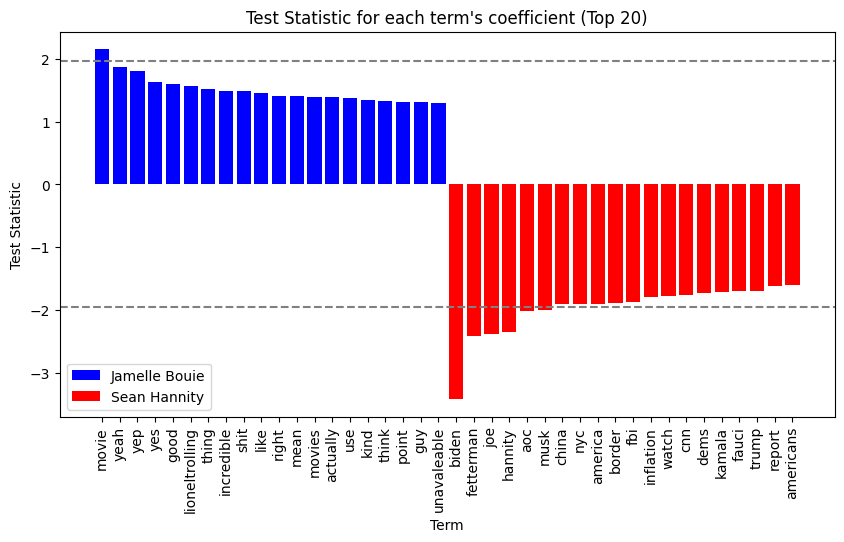

In [87]:
# Separate the top 20 terms of each candidate
coefs_jb = coefs.sort_values('test_statistic', ascending=False).iloc[:20]
coefs_sh = coefs.sort_values('test_statistic', ascending=True).iloc[:20]

# Plot the top 20 terms for each candidate to visualize better
plt.figure(figsize=(10, 5))
plt.bar(coefs_jb.index, coefs_jb['test_statistic'], color='blue', label='Jamelle Bouie')
plt.bar(coefs_sh.index, coefs_sh['test_statistic'], color='red', label='Sean Hannity')
plt.axhline(y=1.96, color='gray', linestyle='--')
plt.axhline(y=-1.96, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.title('Test Statistic for each term\'s coefficient (Top 20)')
plt.xlabel('Term')
plt.ylabel('Test Statistic')
plt.legend()
plt.show()


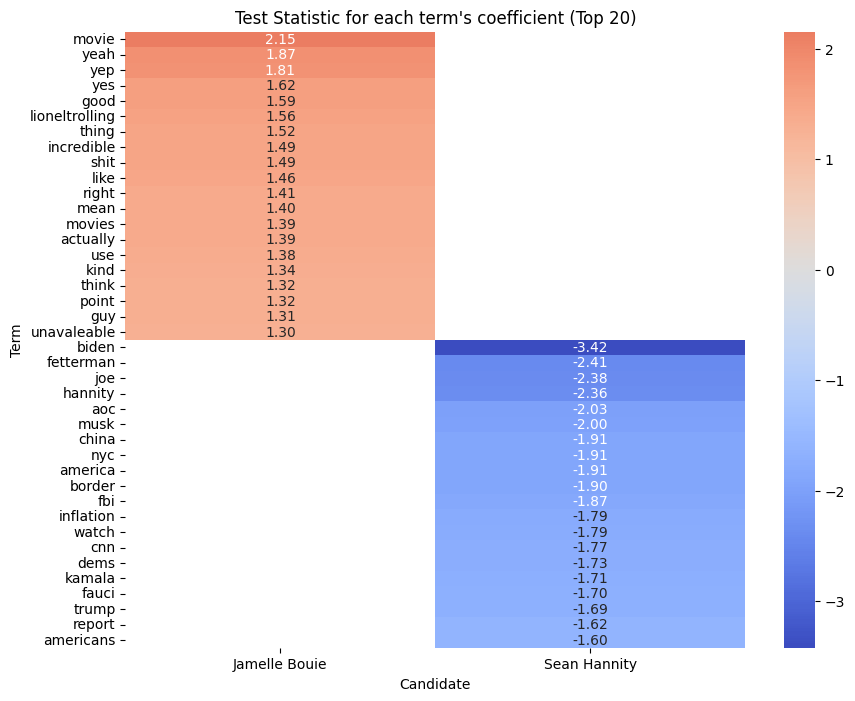

In [88]:
# Create a DataFrame with the top 20 terms for each candidate
top_terms_jb = pd.DataFrame(index=coefs_jb.index, columns=['Jamelle Bouie'])
top_terms_jb['Jamelle Bouie'] = coefs_jb['test_statistic']
top_terms_sh = pd.DataFrame(index=coefs_sh.index, columns=['Sean Hannity'])
top_terms_sh['Sean Hannity'] = coefs_sh['test_statistic']
top_terms = pd.concat([top_terms_jb, top_terms_sh], axis=1)

# Plot a heatmap of the top 20 terms for each candidate
plt.figure(figsize=(10, 8))
sns.heatmap(top_terms, cmap='coolwarm', annot=True, fmt='.2f', center=0)
plt.title('Test Statistic for each term\'s coefficient (Top 20)')
plt.xlabel('Candidate')
plt.ylabel('Term')
plt.show()

In [89]:
# calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'The test set accuracy: {accuracy*100:.4f}%')

The test set accuracy: 93.1067%
